# TP3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en  
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Inciso 1

### Funcion encontrar_logo_coca

In [13]:
def encontrar_logo_coca(img, patron='template/pattern.png',
                        meth='cv.TM_CCOEFF_NORMED', k_blur=15, sigma_blur=2, min_sf=.4):

    '''
    Función para encontrar el template en diversas imágenes.
    Devuelve la imagen original con un rectángulo alrededor del objeto
    encontrado.

    param img: imagen en la cual se va a buscar el template
    param patron: ubicación del archivo del template
    param meth: método utilizado
    param k_blur: tamaño del kernel del defengoque gaussiano
    param sigma_blur: sigma del desenfoque gaussiano
    param min_sf: mínimo factor de escala para reescalar el template
    '''

    # Defino una función para generar generar lista de imagenes escaladas
    def escalar(img, escalas=[0.5,1,2]):
        '''
        Devuelve una lista de imagenes reescaladas
        param img: imagen a reescalar
        param escalas: lista de escalas
        '''
        scales = escalas
        resized_imgs = list()
        # generamos nuestras "piramides" de tamaños arbitrarios
        for scale in scales:
            img_resized = img.copy()
            resized_imgs.append(cv.resize(img_resized, None, fx=scale, fy=scale))        
        return resized_imgs
    
        
    img_rgb    = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray   = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Aplico filtro gaussiano a la imagen
    img_blured = cv.GaussianBlur(img_gray, ksize=(k_blur,k_blur), sigmaX=sigma_blur, sigmaY=sigma_blur)
    # Leo el template
    template   = cv.imread(patron,0)
    # Aplico Canny a imagen
    img_blured = cv.Canny(img_blured, threshold1=5, threshold2=200)
    # template   = cv.Canny(template, threshold1=5, threshold2=200)
    
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    
    # meth = 'cv.TM_CCOEFF'
    method = eval(meth)
    
    # Generamos diferentes escalas del template
    # calculo el tamaño máximo del template escalado para no pasarme de alguna dimensión de la imagen
    max_scale_admitida = np.min([(img.shape[0]/template.shape[0]), (img.shape[1]/template.shape[1])])    
    escalas = np.linspace(min_sf,max_scale_admitida,20)    
    templates_scaladed = escalar(template, escalas)

    min_val_final = 1000000
    max_val_final = -1000000
    res_final = None

    for template_scaladed in templates_scaladed:
        
        # Aplico la coincidencia de patrones
        #--------------------------------------
        # aplico Canny al templates escalado
        template_scaladed   = cv.Canny(template_scaladed, threshold1=5, threshold2=200)
        res = cv.matchTemplate(img_blured, template_scaladed, method)
        
        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            if min_val < min_val_final:
                min_val_final = min_val
                top_left = min_loc
                template_final = template_scaladed
                w, h = template_final.shape[::-1]
                res_final = res
        else:        
            if max_val > max_val_final:
                max_val_final = max_val
                top_left = max_loc
                template_final = template_scaladed
                w, h = template_final.shape[::-1]
                res_final = res


    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, (0, 255, 0), 2)
    
    print('Valor Obtenido por el método {} = {}'.format(meth, max_val_final))
    print('Tamaño Imagen: {}'.format(img.shape))
    print('Tamaño Template Orig: {}'.format(template.shape))
    print('Tamaño Template Scaled: {}'.format(template_final.shape))

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure(figsize=(16,16))
    
    # Resultado de coincidencia
    plt.subplot(141),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(142),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(143),plt.imshow(template_final, cmap='gray')
    plt.title('Template Scaled')
    plt.subplot(144),plt.imshow(img_blured, cmap='gray')
    plt.title('Matching Image')

    plt.suptitle(meth)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()

    return res_final

### Aplicacion funcion encontrar_logo_coca a diversas imagenes

#### coca_logo_1.png

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.11815730482339859
Tamaño Imagen: (500, 207, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (79, 180)


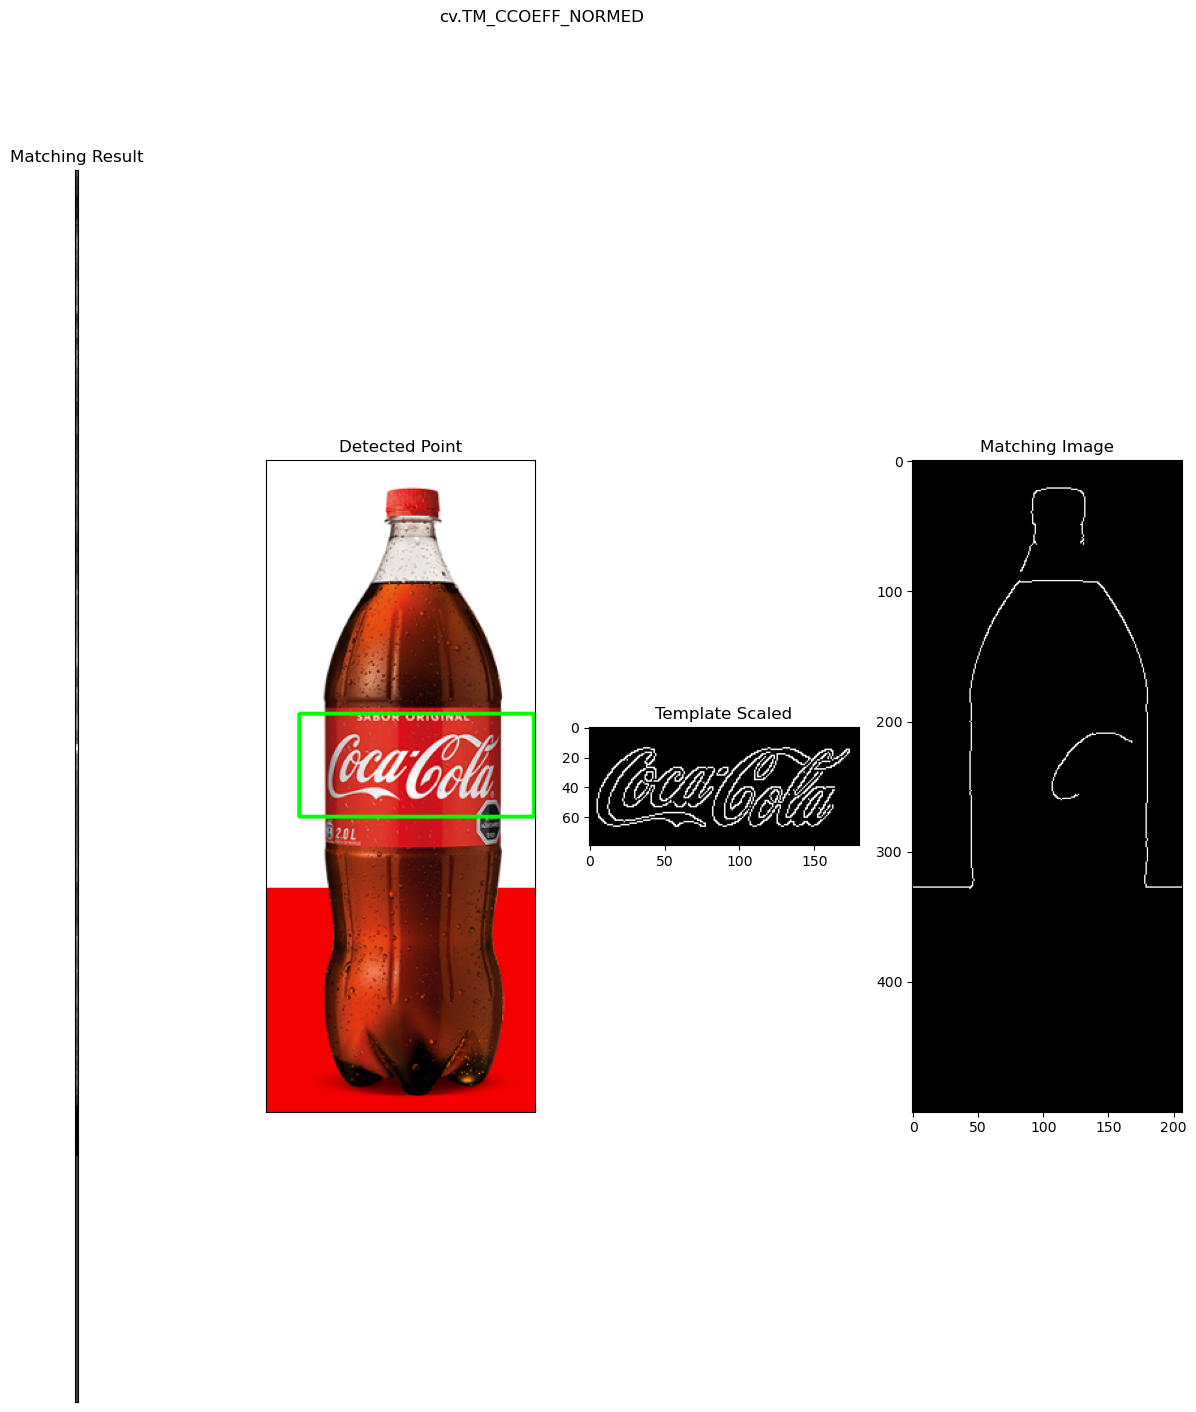

In [3]:
img = cv.imread('images/coca_logo_1.png')
res = encontrar_logo_coca(img)

#### coca_logo_2.png

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.089369036257267
Tamaño Imagen: (363, 233, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (72, 164)


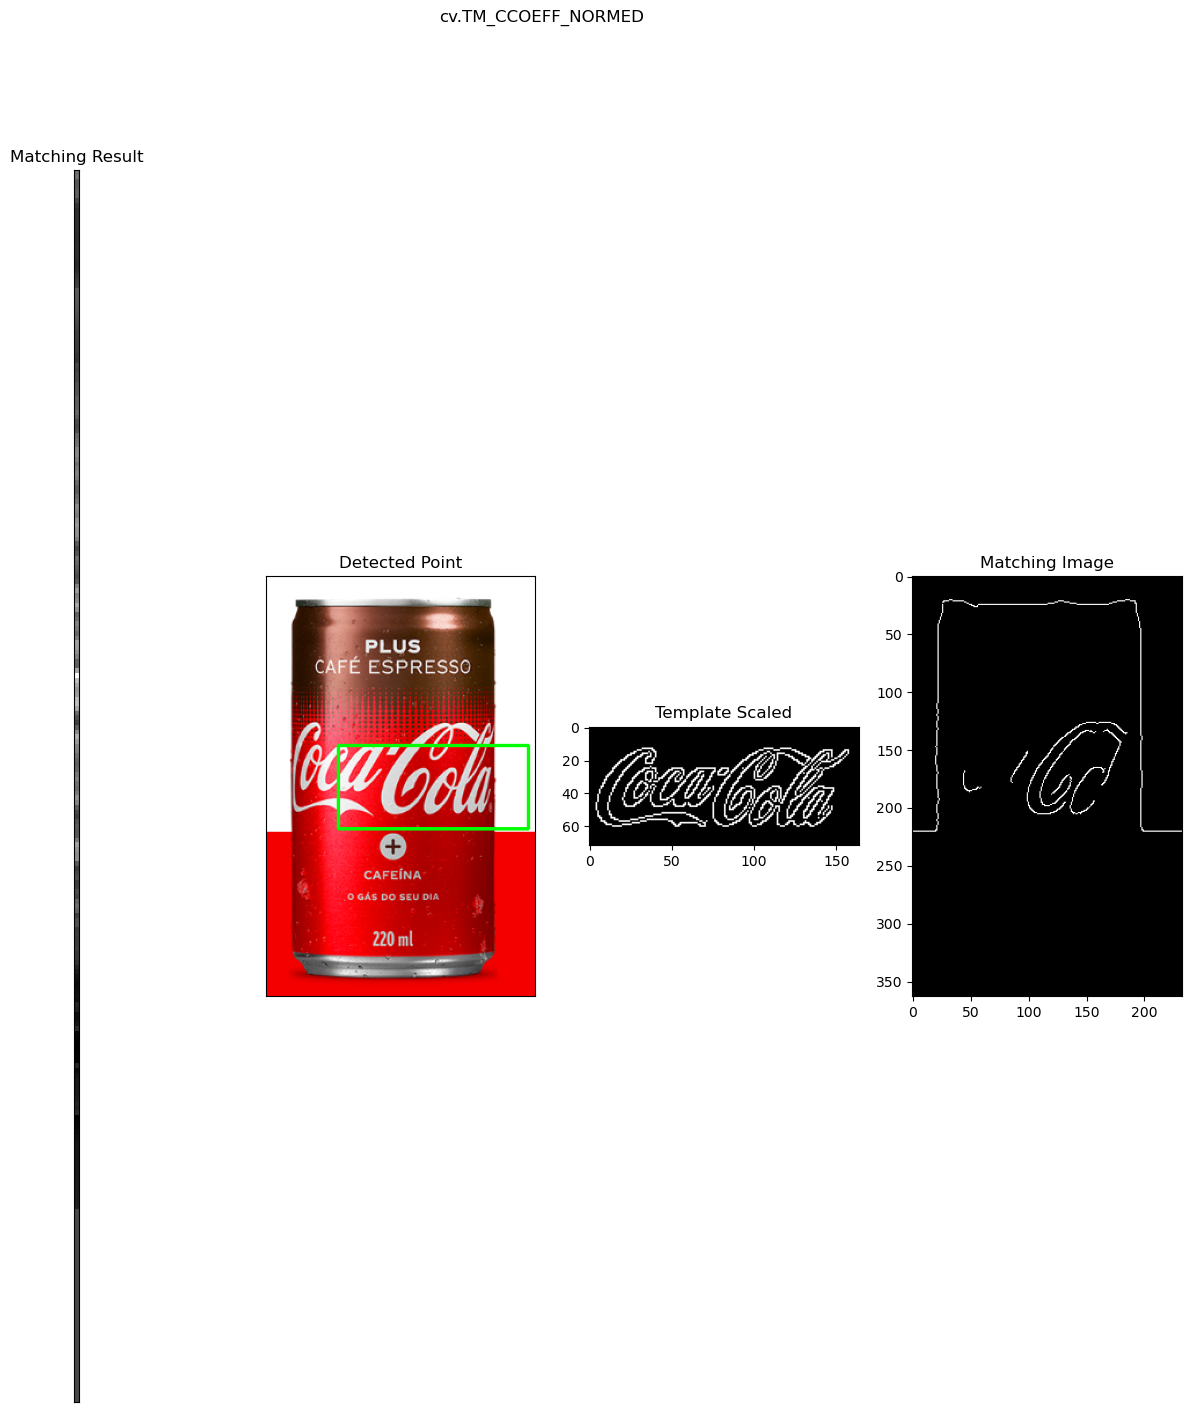

In [4]:
img = cv.imread('images/coca_logo_2.png')
res = encontrar_logo_coca(img)

#### coca_retro_1.png

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.21351537108421326
Tamaño Imagen: (197, 286, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (93, 213)


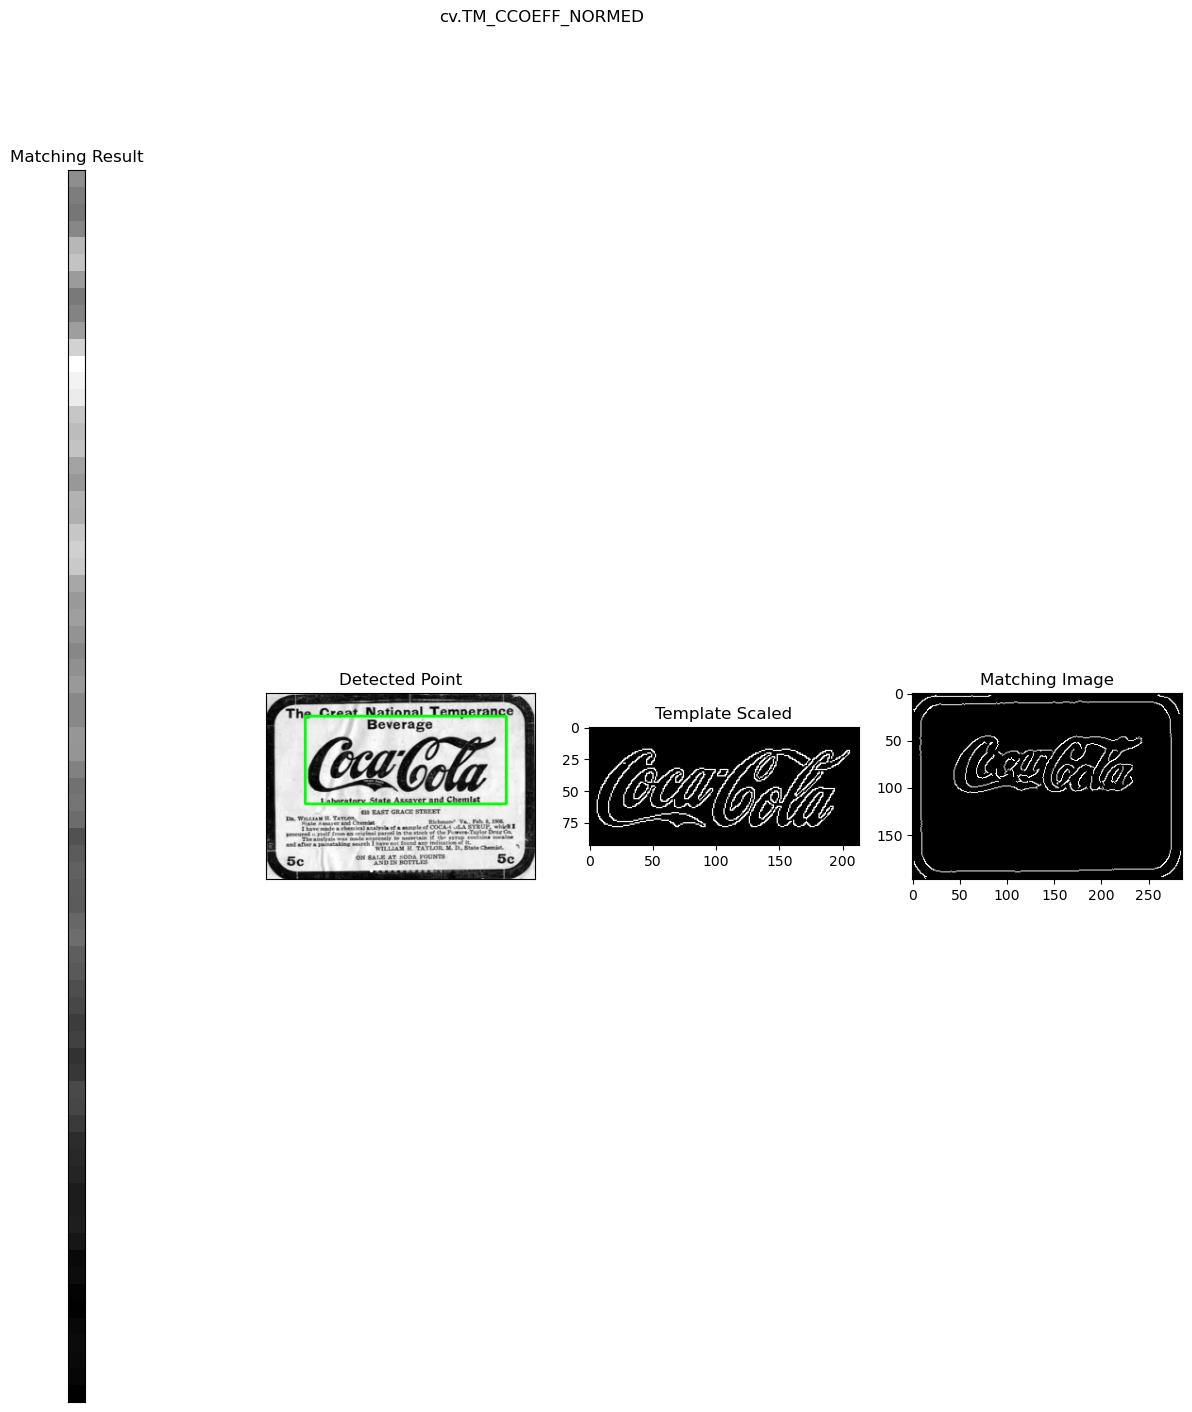

In [32]:
img = cv.imread('images/coca_retro_1.png')
img = cv.resize(img, None, fx=.4, fy=.4)
res = encontrar_logo_coca(img, k_blur=15, sigma_blur=2.9)

#### coca_retro_2

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.27055105566978455
Tamaño Imagen: (429, 715, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (70, 160)


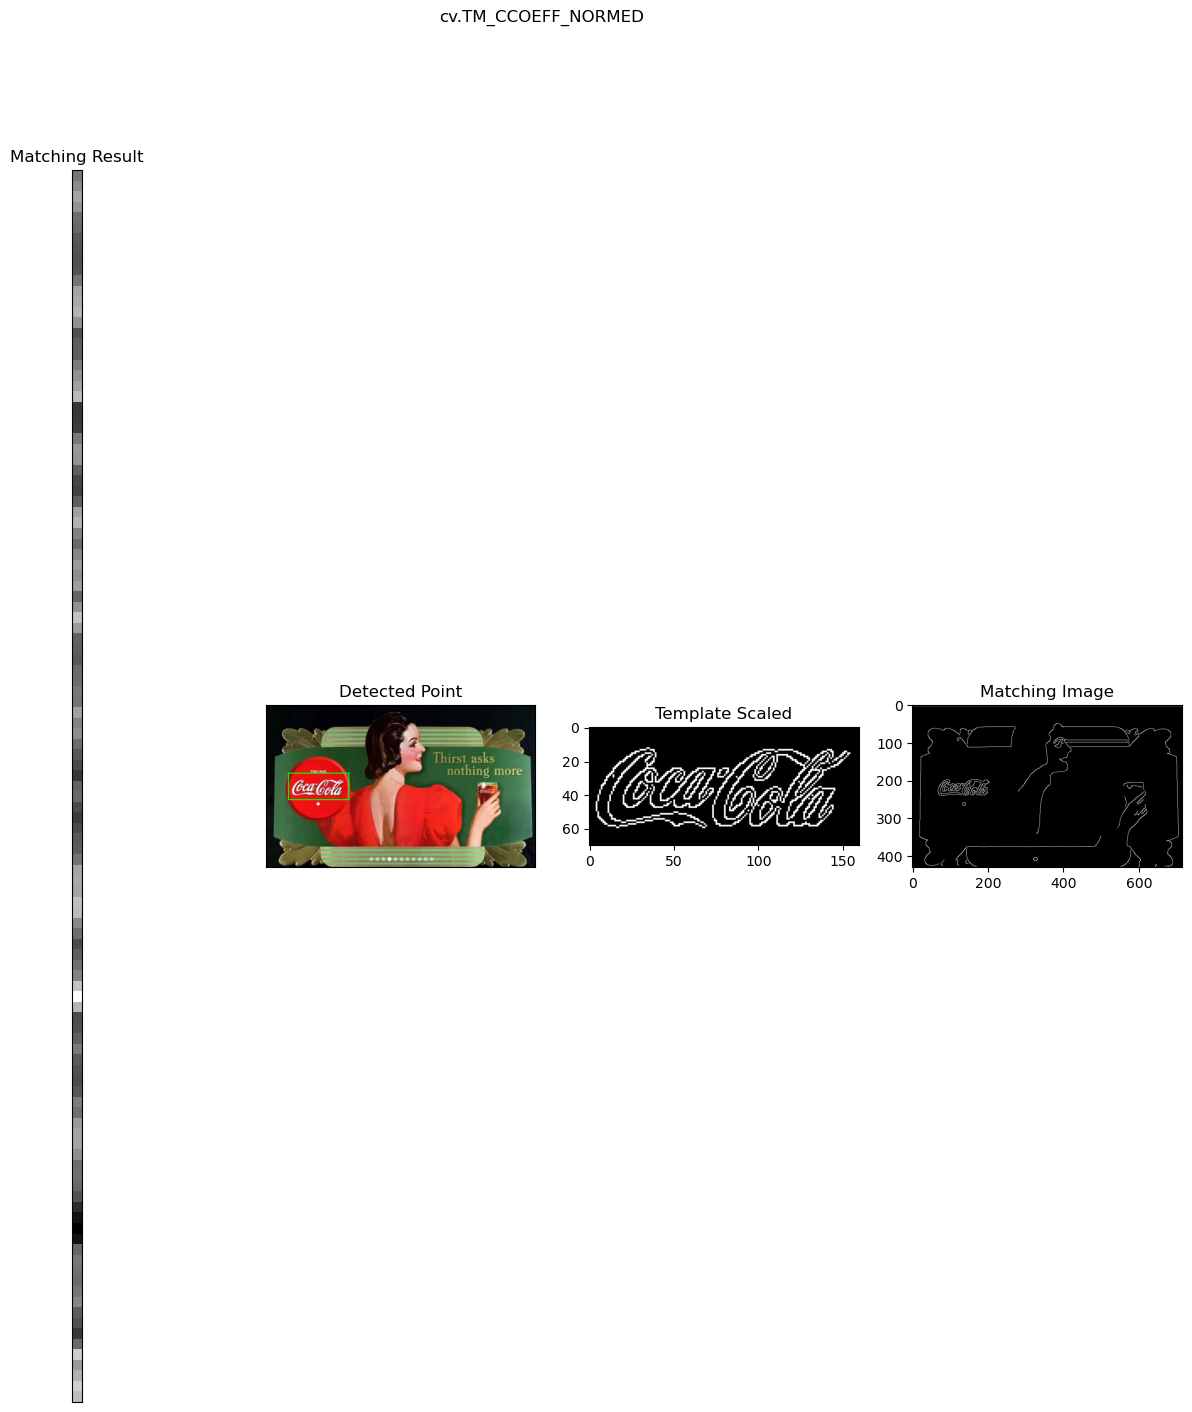

In [14]:
img = cv.imread('images/coca_retro_2.png')
res = encontrar_logo_coca(img)

#### COCA-COLA-LOGO.jpg

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.23817792534828186
Tamaño Imagen: (278, 278, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (111, 253)


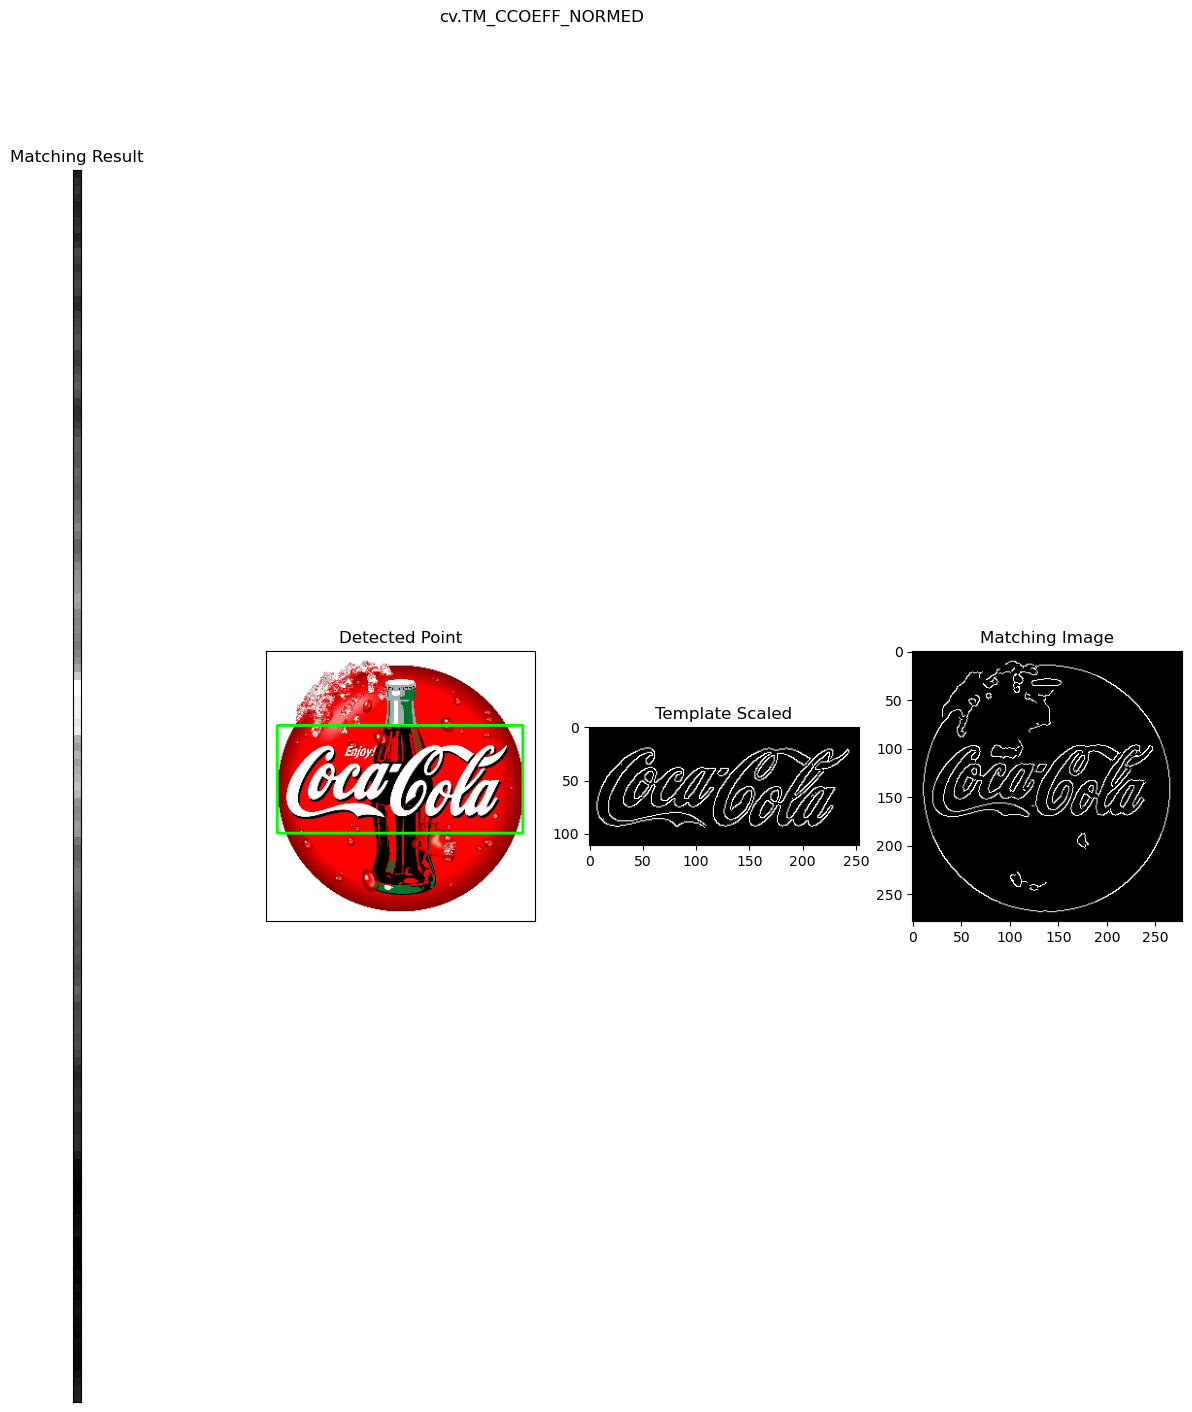

In [7]:
img = cv.imread('images/COCA-COLA-LOGO.jpg')
img = cv.resize(img, None, fx=0.2, fy=0.2)
res = encontrar_logo_coca(img, sigma_blur=2)

#### logo_1.png

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.07288580387830734
Tamaño Imagen: (450, 687, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (70, 160)


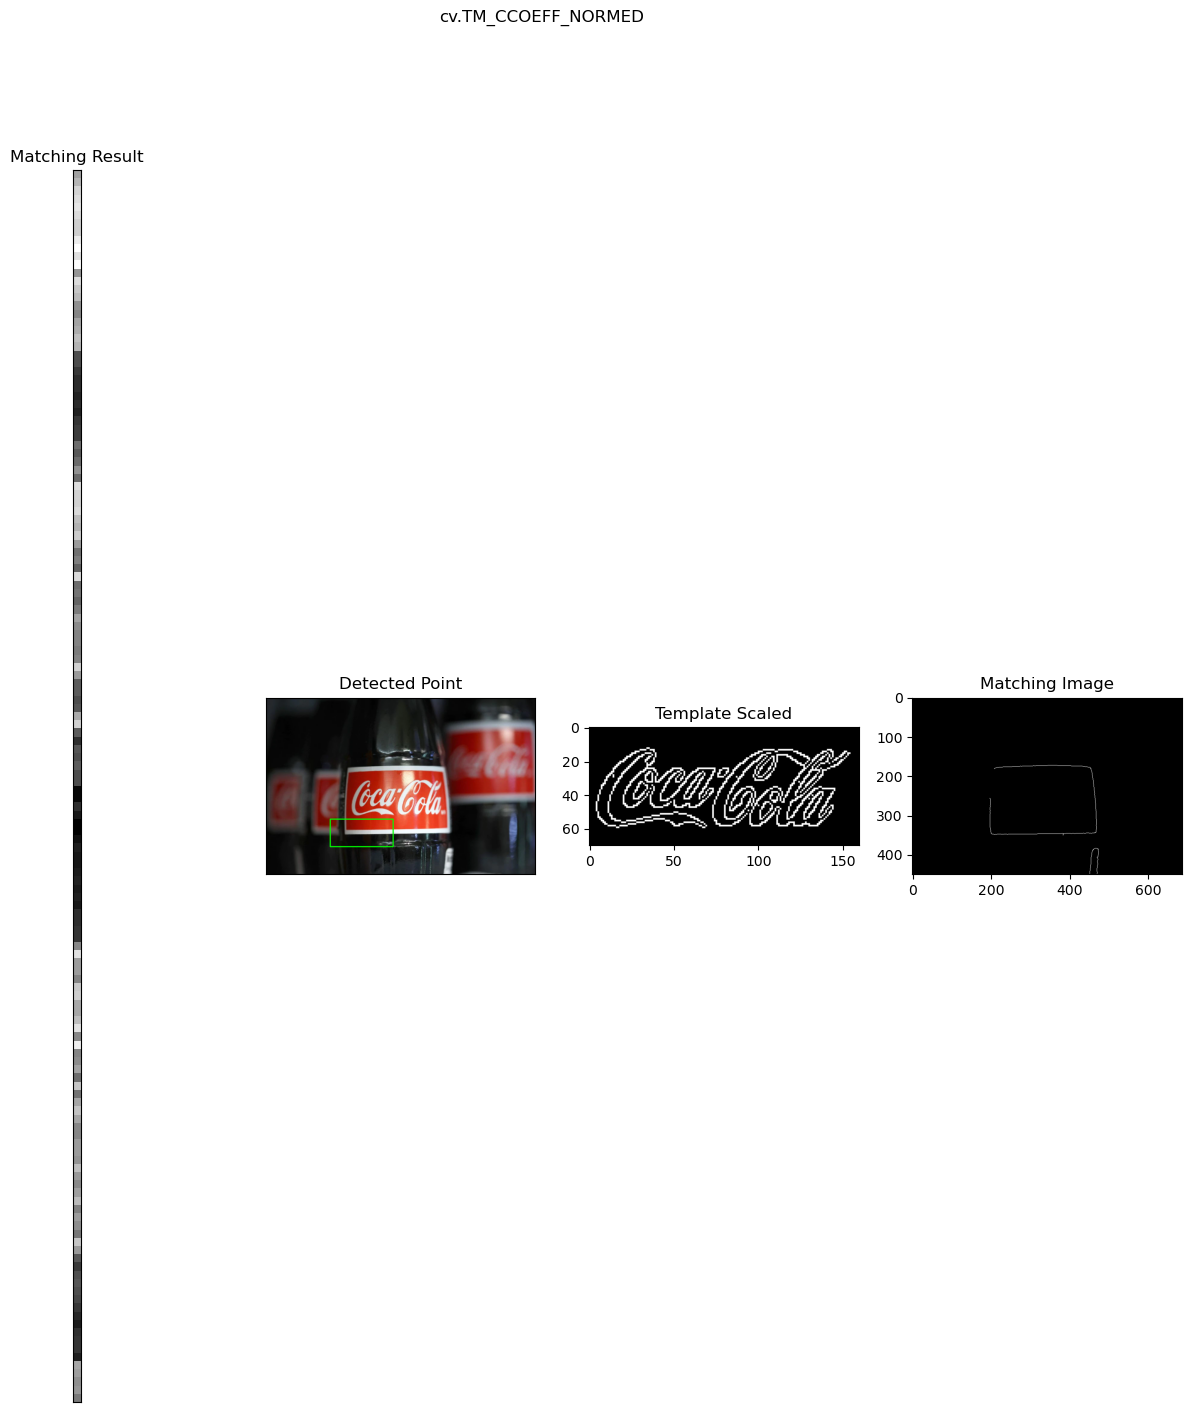

In [8]:
img = cv.imread('images/logo_1.png')
res = encontrar_logo_coca(img)

## Inciso 2

In [9]:
img_rgb = cv.imread('images/coca_multi.png')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template_orig = cv.imread('template/pattern.png',0)

# Hago un resize del template al tamaño óptimo
template = cv.resize(template_orig, (100, 44))

k_size = 5
sigma_blur = 2


# Aplico filtro gaussiano a la imagen
img_blured = cv.GaussianBlur(img_gray, ksize=(k_size,k_size),
                             sigmaX=sigma_blur, sigmaY=sigma_blur)

# Aplico Canny a template e imagen
template   = cv.Canny(template, threshold1=5, threshold2=200)
img_blured = cv.Canny(img_blured, threshold1=5, threshold2=200)


w, h = template.shape[::-1]
res = cv.matchTemplate(img_blured,template,cv.TM_CCOEFF_NORMED)
# Fijamos un umbral de "coincidencia"
threshold = 0.22

min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

# cv.rectangle(img_rgb,top_left, bottom_right, 255, 2)

loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)

cv.imshow("template",template)
cv.imshow("cocas",img_rgb)

cv.waitKey()
cv.destroyAllWindows()

print(img_gray.shape)
print(template_orig.shape)
print(template.shape)

print(min_val, max_val, min_loc, max_loc)

(598, 799)
(175, 400)
(44, 100)
-0.11887749284505844 0.23028765618801117 (252, 91) (558, 426)


In [10]:
res

array([[ 0.01138126,  0.01138126,  0.01138126, ..., -0.00414663,
        -0.00802859, -0.00414661],
       [-0.05073025, -0.05073024, -0.05073025, ...,  0.00361726,
         0.00749924,  0.00749923],
       [-0.07013999, -0.07013999, -0.07013999, ...,  0.02302713,
         0.02302713,  0.02302713],
       ...,
       [ 0.0672099 ,  0.0672099 ,  0.06361388, ..., -0.02146931,
        -0.02097503, -0.02047835],
       [ 0.0773746 ,  0.0696107 ,  0.06961067, ..., -0.00809896,
        -0.00755801, -0.00701417],
       [ 0.03079105,  0.03467305,  0.03855499, ..., -0.03331292,
        -0.03283125, -0.03234712]], dtype=float32)

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.2152160406112671
Tamaño Imagen: (598, 799, 3)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (44, 100)


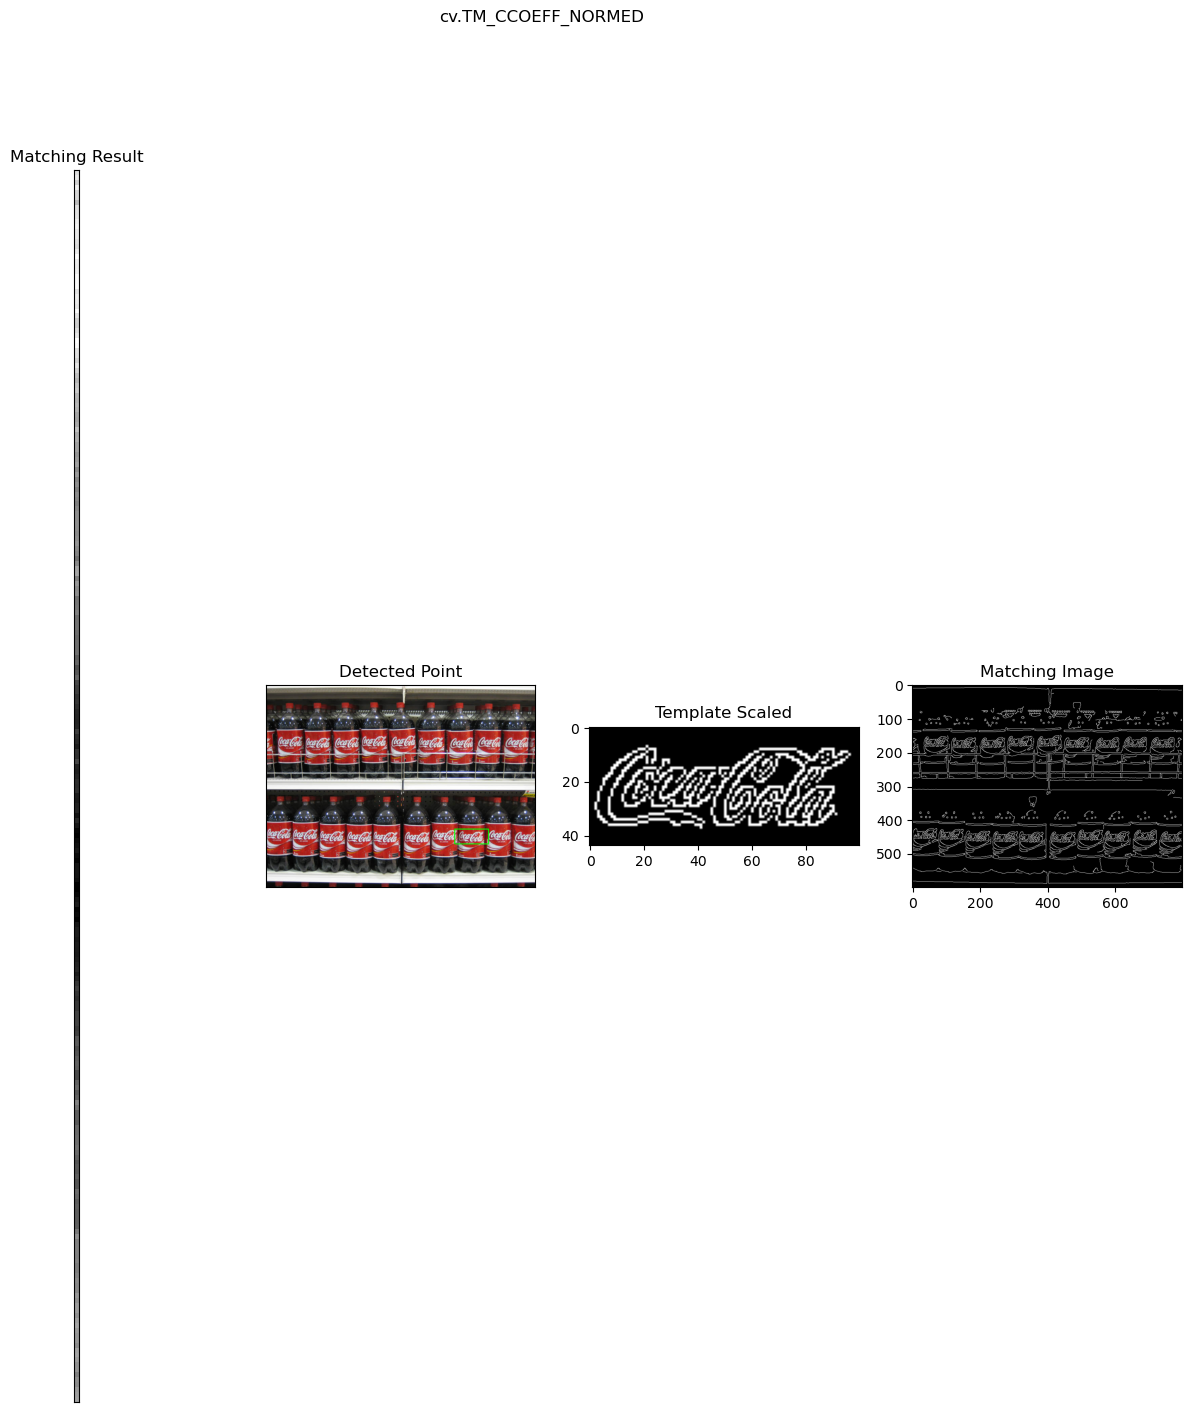

In [11]:
img = cv.imread('images/coca_multi.png')
res2 = encontrar_logo_coca(img, k_blur=5, sigma_blur=2, min_sf=0.25)

In [12]:
img = cv.imread('images/COCA-COLA-LOGO.jpg')

patron='template/pattern.png'
# original
template_orig   = cv.imread(patron,0)
# reescalado
new_size = (1260, 551)
template        = cv.resize(template_orig, new_size)

# Original con canny
template_orig_canny = cv.Canny(template_orig, threshold1=150, threshold2=200)
# Reescalado con canny
template      = cv.Canny(template, threshold1=150, threshold2=200)
# Original con canny, luego escalado
template2     = cv.resize(template_orig_canny, new_size)


cv.imshow('template_orig_canny', template_orig_canny)
cv.imshow('template', template)
cv.imshow('template2', template2)



cv.waitKey(0)
cv.destroyAllWindows()